# Exercises: Finding Local Peaks in a 2-D Array

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.morphology import iterate_structure

from typing import Tuple, Callable, List

%matplotlib notebook

/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_84223/577117018.py:6: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_84223/577117018.py:7: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure
/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_84223/577117018.py:8: DeprecationWarning: Please use `iterate_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import iterate_structure


## Toy Problem

We want to find the primary points of contact made by puppy-paws on a pressure-sensor.
There are $4$ images that are each $11\times14$ pixels. 
Let's load and visualize this data.

In [2]:
# loads four images of puppy paw print pressure data
paws = np.loadtxt("data/paws.txt").reshape(4, 11, 14)
print(paws.shape)

(4, 11, 14)


<IPython.core.display.Javascript object>


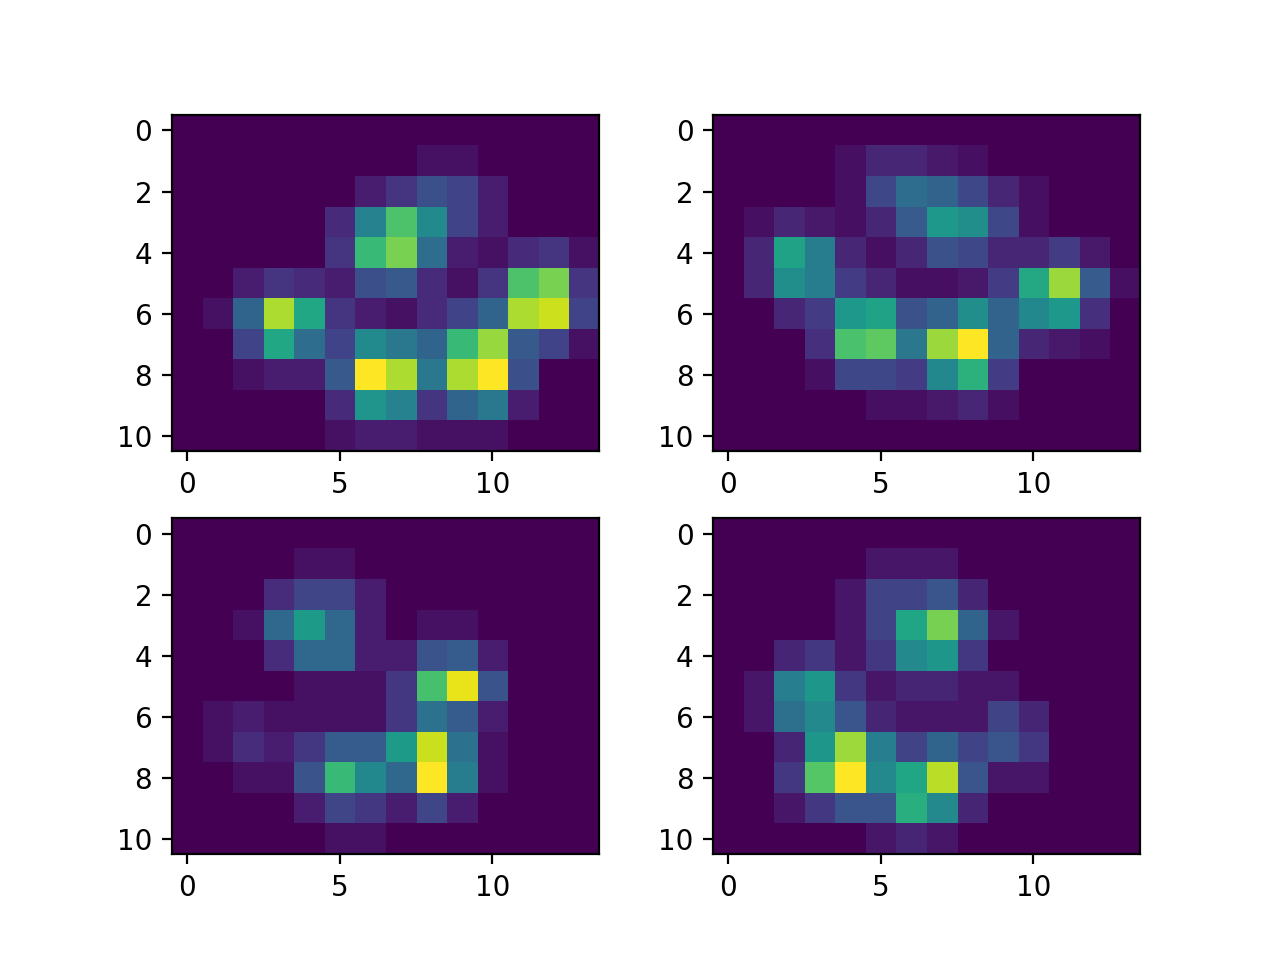

In [3]:
# plots the paw prints
fig, ax = plt.subplots(nrows=2, ncols=2)
for n, (i, j) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    ax[i, j].imshow(paws[n])

For each "toe", we want to find the pixel with the maximum pressure.
This corresponds to a finding the local peaks in a 2-D image.
This is much more nuanced than finding the global maximum.
The term "local peak" is also not completely well defined - we need to specify what we mean by "local".

### Defining a 2D neighborhood

In order to find local peaks in our 2D data, we must first define what we mean by "local". We will use `scipy.ndimage.morphology.generate_binary_structure` and `from scipy.ndimage.morphology.iterate_structure` to generate a 2D boolean-valued array that represents our neighborhood.

`generate_binary_structure` produces the a simple 2-D array of boolean values that indicate where we want to look within the neighborhood (i.e. `True` marks the elements that are included in the neighborhood).

Let's generate and visualize this specific neighborhood

In [4]:
generate_binary_structure(rank=2, connectivity=1)

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

<IPython.core.display.Javascript object>


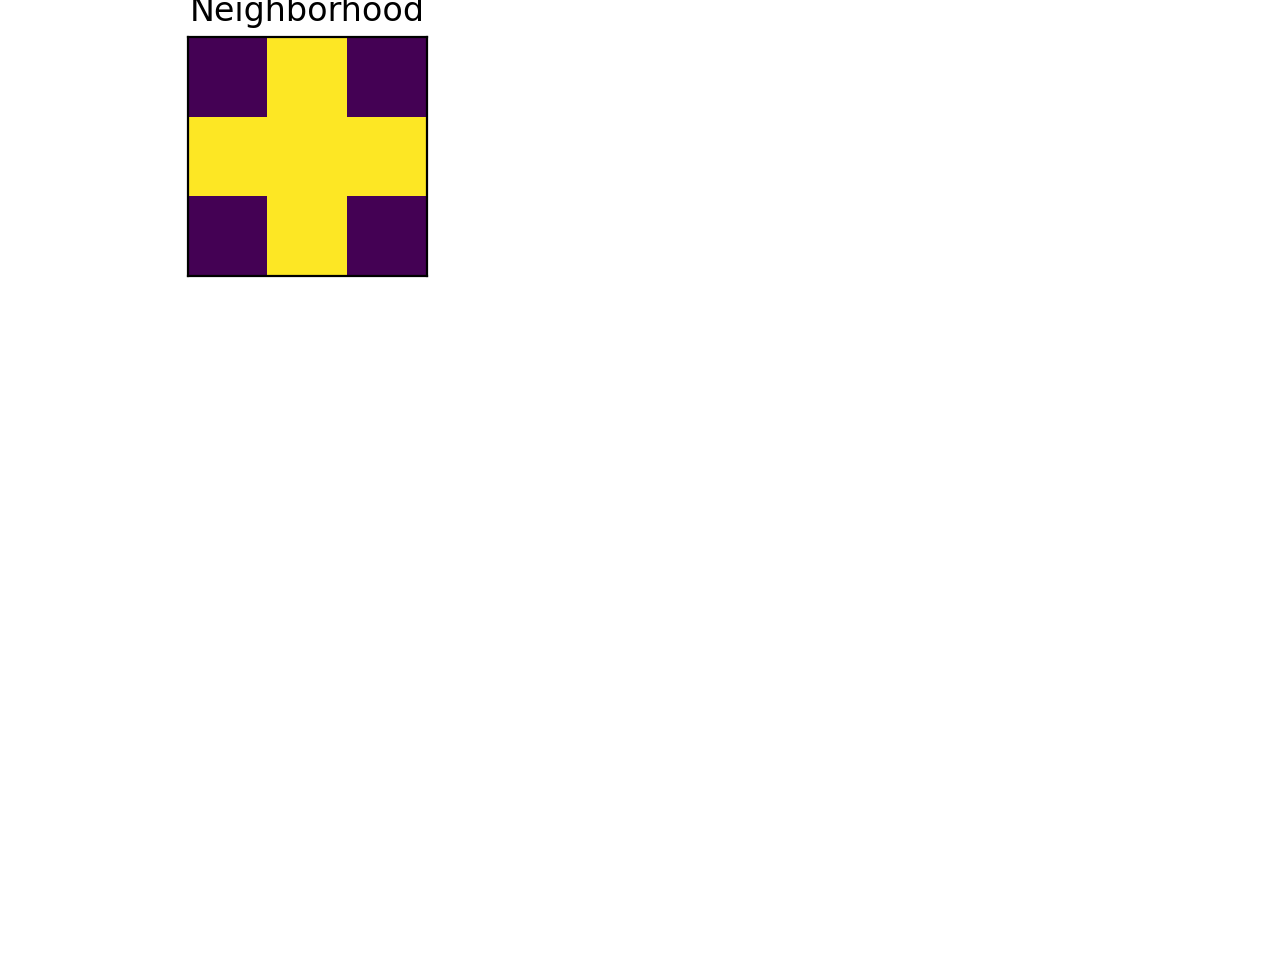

In [5]:
fig, ax = plt.subplots()
ax.imshow(generate_binary_structure(rank=2, connectivity=1))
ax.set_title("Rank-2, Connectivity-1\nNeighborhood")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

What if we want to use a larger neighborhood? We can make use of `scipy.ndimage.morphology.iterate_structure` to "grow" the pattern created by `generate_binary_structure(2, 1)`.
This allows us to set roughly the number of nearest neighbors (along a given direction) that that we want to included in the neighborhood.

For instance, let's use `iterate_structure` to generate a neighborhood that includes two "neighbors" to each cardinal side (i.e. above/below and to the left/right) of the center element of the neighborhood:

```python
>>> base_structure = generate_binary_structure(2,1)
>>> neighborhood = iterate_structure(base_structure, 2)
>>> neighborhood
array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]], dtype=bool)
```

<IPython.core.display.Javascript object>


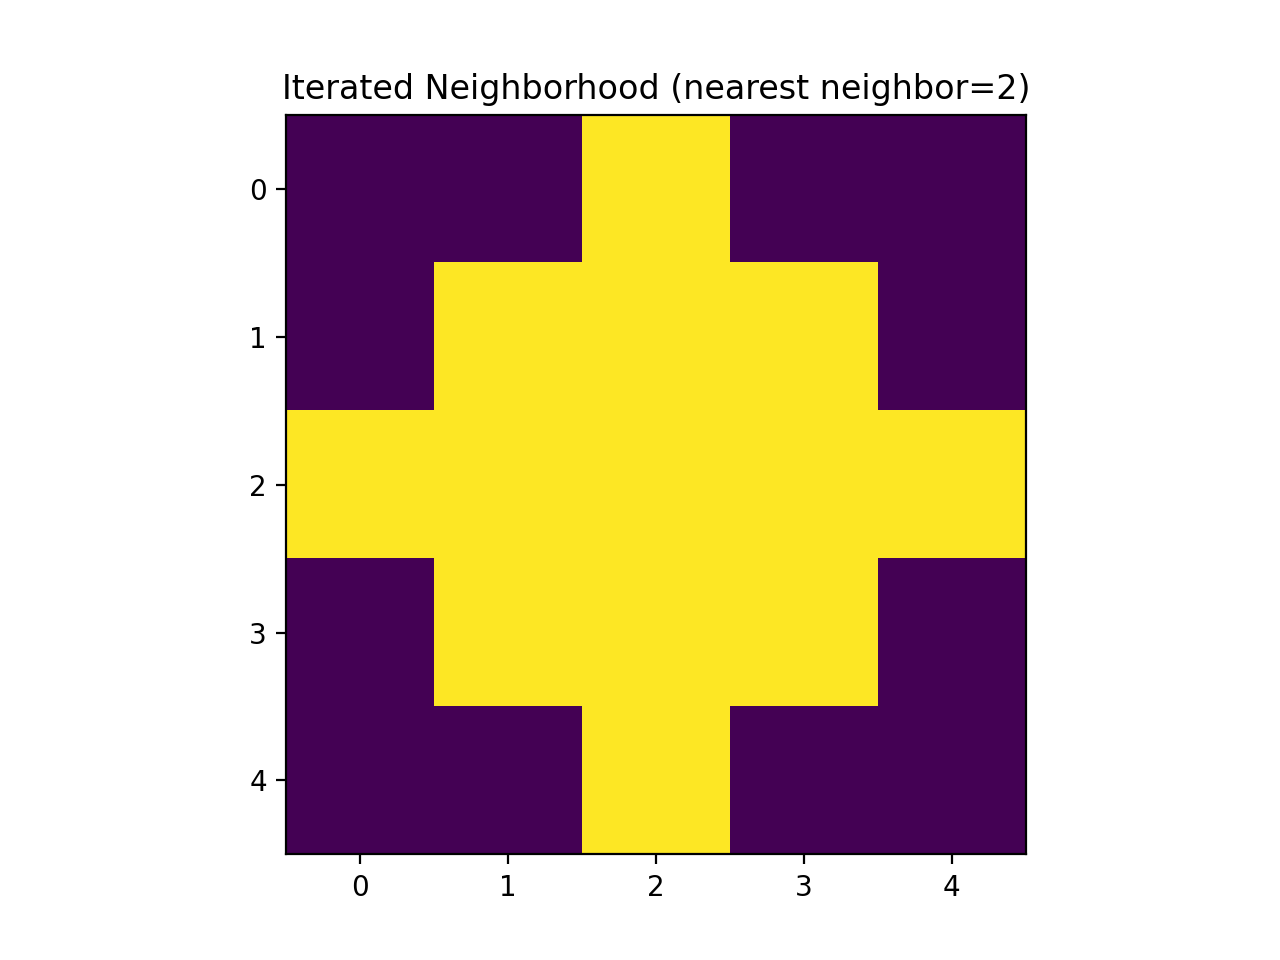

In [6]:
fig, ax = plt.subplots()

base_structure = generate_binary_structure(2,1)
neighborhood = iterate_structure(base_structure, 2)

ax.imshow(neighborhood)
ax.set_title("Iterated Neighborhood (nearest neighbor=2)");

(1.8.1) Use `iterate_structure` to create a neighborhood the includes three "neighbors" to each side (left, right, top, and bottom respectively) of the center element.


In [7]:
# STUDENT CODE HERE
fig, ax = plt.subplots()

neighborhood = iterate_structure(base_structure, 4)

ax.imshow(neighborhood)
ax.set_title("Iterated Neighborhood (nearest neighbor=2)");

In general, we will always generate a neighborhood array that has an odd number of rows and columns, respectively.
This will ensure that our neighborhood has an unambiguous center element. 


### Finding the Actual Peaks

The following code slides this "local neighborhood mask" over our grid of 2D data (e.g. our spectrogram of amplitudes).
For whichever element the neighborhood is centered on, we see if:

- That center element is larger than some minimum threshold, which must be exceeded as a requirement to be considered "a peak"
- No neighbor (as defined by the neighborhood) is larger than that center element

If these conditions are true, then that center element is considered to be a local peak.
We then iterate to the next element in the 2D array and repeat the process; ultimately we will have iterated over the entire 2D array of data to so identify all of the local peaks.
Note that this is a relatively simple way of doing local peak-finding, and is certainly not the most optimal algorithm to do so.

Doing for-loops over large numpy arrays is typically something that we avoid doing due to considerations of speed.
But we do not have access to a vectorized peak-finding algorithm, so for-loops are what we have to stick with.
Fortunately, we can leverage a package called Numba to help speed up this code.
Numba provides a "just in time" (JIT) compiler that is able to translate (some aspects of) Python code into optimized machine code.
That is, whereas we have typically avoided writing for-loops over large arrays of data in Python in favor of vectorization, Numba enables us to write plain Python code using for-loops, but obtain a function that will run quickly, as if it had been implemented in a fast, compiled language like C.

Study the following code to understand what is going on.

In [ ]:
from numba import njit

# `@njit` "decorates" the `_peaks` function. This tells Numba to
# compile this function using the "low level virtual machine" (LLVM)
# compiler. The resulting object is a Python function that, when called,
# executes optimized machine code instead of the Python code
# 
# The code used in _peaks adheres strictly to the subset of Python and
# NumPy that is supported by Numba's jit. This is a requirement in order
# for Numba to know how to compile this function to more efficient
# instructions for the machine to execute
@njit
def _peaks(
    data_2d: np.ndarray, nbrhd_row_offsets: np.ndarray, nbrhd_col_offsets: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    nbrhd_row_offsets : numpy.ndarray, shape-(N,)
        The row-index offsets used to traverse the local neighborhood.
        
        E.g., given the row/col-offsets (dr, dc), the element at 
        index (r+dr, c+dc) will reside in the neighborhood centered at (r, c).
    
    nbrhd_col_offsets : numpy.ndarray, shape-(N,)
        The col-index offsets used to traverse the local neighborhood. See
        `nbrhd_row_offsets` for more details.
        
    amp_min : float
        All amplitudes equal to or below this value are excluded from being
        local peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned in 
        column-major order
    """
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterating over each element in the the 2-D data 
    # in column-major ordering
    #
    # We want to see if there is a local peak located at
    # row=r, col=c
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c) to see
        # if (r, c) is associated with the largest value in that
        # neighborhood.
        #
        # dr: offset from r to visit neighbor
        # dc: offset from c to visit neighbor
        for dr, dc in zip(nbrhd_row_offsets, nbrhd_col_offsets):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary.. skip!
                continue

            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary.. skip!
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a local peak
            peaks.append((r, c))
    return peaks

# `local_peak_locations` is responsible for taking in the boolean mask `neighborhood`
# and converting it to a form that can be used by `_peaks`. This "outer" code is 
# not compatible with Numba which is why we end up using two functions:
# `local_peak_locations` does some initial pre-processing that is not compatible with
# Numba, and then it calls `_peaks` which contains all of the jit-compatible code
def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    
    Notes
    -----
    The local peaks are returned in column-major order, meaning that we 
    iterate over all nbrhd_row_offsets in a given column of `data_2d` in search for
    local peaks, and then move to the next column.
    """

    # We always want our neighborhood to have an odd number
    # of nbrhd_row_offsets and nbrhd_col_offsets so that it has a distinct center element
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1
    
    # Find the indices of the 2D neighborhood where the 
    # values were `True`
    #
    # E.g. (row[i], col[i]) stores the row-col index for
    # the ith True value in the neighborhood (going in row-major order)
    nbrhd_row_indices, nbrhd_col_indices = np.where(neighborhood)
    

    # Shift the neighbor indices so that the center element resides 
    # at coordinate (0, 0) and that the center's neighbors are represented
    # by "offsets" from this center element.
    #
    # E.g., the neighbor above the center will has the offset (-1, 0), and 
    # the neighbor to the right of the center will have the offset (0, 1).
    nbrhd_row_offsets = nbrhd_row_indices - neighborhood.shape[0] // 2
    nbrhd_col_offsets = nbrhd_col_indices - neighborhood.shape[1] // 2

    return _peaks(data_2d, nbrhd_row_offsets, nbrhd_col_offsets, amp_min=amp_min)

Complete the following function.

In [ ]:
def local_peaks_mask(data: np.ndarray, cutoff: float) -> np.ndarray:
    """Find local peaks in a 2D array of data and return a 2D array
    that is 1 wherever there is a peak and 0 where there is not.

    Parameters
    ----------
    data : numpy.ndarray, shape-(H, W)

    cutoff : float
         A threshold value that distinguishes background from foreground

    Returns
    -------
    Binary indicator, of the same shape as `data`. The value of
    1 indicates a local peak."""
    # Generate a rank-2, connectivity-2 neighborhood array
    # We will not use `iterate_structure` in this example
    neighborhood_array = #

    # Use that neighborhood to find the local peaks in `data`.
    # Pass `cutoff` as `amp_min` to `local_peak_locations`.
    peak_locations = #

    # Turns the list of (row, col) peak locations into a shape-(N_peak, 2) array
    # Save the result to the variable `peak_locations`
    peak_locations = np.array(peak_locations)

    # create a boolean mask of zeros with the same shape as `data`
    mask = np.zeros(data.shape, dtype=bool)

    # populate the local peaks with `1`
    mask[peak_locations[:, 0], peak_locations[:, 1]] = 1
    return mask

Here is a function that will plot the paw prints next to the binary indicator of the local peaks.

In [ ]:
def plot_compare(
    data: np.ndarray,
    peak_rendering_func: Callable[[np.ndarray], np.ndarray],
    cutoff: float = -np.inf,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the original data side-by-side with the binary indicator
    for the local peaks.

    Parameters
    ----------
    data : numpy.ndarray, shape=(N, H, W)
        N 2D arrays of shape (H, W)

    peak_finding_function : Callable[[ndarray], ndarray]
        A function that will locate the 2D peaks in `data` and
        create an image with the 2D peaks 

    cutoff : float, optional (default=-np.inf)
         A threshold value that distinguishes background from foreground
         
    Returns
    -------
    Tuple[matplotlib.Figure, matplotlib.Axes]
        The figure and axes objects of the plot
    """
    fig, ax = plt.subplots(nrows=len(data), ncols=2)
    for i, dat in enumerate(data):
        ax[i, 0].imshow(dat)
        ax[i, 1].imshow(peak_rendering_func(dat, cutoff=cutoff))
    return fig, ax

(1.8.5) Now we will plot a comparison of our original data vs the peaks that we identify in the data.

In [ ]:
plot_compare(paws, local_peaks_mask);

What do you see in these right-column images? 
Are these precisely the results we are looking for? 
What seems to be off?

Hint: Inspect the paw print data.
What value is used to represent the background of the image?
What is the default value for `cutoff` in `plot_compare` for distinguishing between foreground and background?

> *SOLUTION HERE*


Use `plot_compare` again, but this time adjust amplitude cutoff threshold value in order to exclude the background from the peak-finding algorithm.


In [ ]:
# STUDENT CODE HERE

Each paw print should have five distinct peaks -- one for each pad in the puppy's paw. If this is what you see, success! We are now finding local peaks in 2-D data!

To summarize this process, we:

 - Defined a neighborhood that was appropriate for measuring local peaks. This made precise what we mean by "local" under specific circumstances.
 - Demanded that our local peaks be in the "foreground" of our data.
 - Rastered our neighborhood across our 2D data, element-by-element and asked: is the center of this neighborhood the largest value of all the elements in this neighborhood (including tied for largest) and is it larger than our cutoff threshold? If so, then it is a local peak in our 2D data. 
 
This will be very useful to help us find the "fingerprint features" of a song, given its spectrogram (frequency vs time) data.

## Identifying "Foreground" vs "Background" in Real Data

Although this puppy paw print data set is pretty adorable, the fact that the paw print features are neatly embedded in a background of $0$s is too convenient.
In reality, we will likely face data where distinguishing background from a salient foreground is subtle (or perhaps entirely ill-posed).

Let's consider, for instance, the spectrogram data for the trumpet waveform.

In [ ]:
# running this cell loads the PCM-encoded data for the trumpet clip
import librosa

trumpet_audio, sampling_rate = librosa.load("data/trumpet.wav", sr=44100, mono=True)

In [ ]:
# using matplotlib's built-in spectrogram function
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(
    trumpet_audio,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Audio Recording")
ax.set_ylim(0, 6000);

To help us identify a "foreground" in the log-amplitudes of the spectrogram, we will plot the *cumulative distribution* of the log-amplitudes.
This will allow us to identify a useful percentile below which we can consider all amplitudes to be "background".

The following function can be used to compute [an empirical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function) (ECDF) of our data.
The ECDF plots, for some dataset, `percentile(x)` vs `x` -- making it easy to see what proportion of values in our
dataset fall below/above any given value `x`.

In [ ]:
import numpy as np

def ecdf(data):
    """Returns (x) the sorted data and (y) the empirical cumulative-proportion
    of each datum.
    
    Parameters
    ----------
    data : numpy.ndarray, size-N
    
    Returns
    -------
    Tuple[numpy.ndarray shape-(N,), numpy.ndarray shape-(N,)]
        Sorted data, empirical CDF values"""
    data = np.asarray(data).ravel()  # flattens the data
    y = np.linspace(1 / len(data), 1, len(data))  # stores the cumulative proportion associated with each sorted datum
    x = np.sort(data)
    return x, y

Let's get a feel for what `ecdf` does by using it to plot the cumulative distribution of our log-scaled spectrogram amplitudes.
We'll plot this side-by-side with a typical histogram of our log-amplitude values

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))


ax1.hist(np.log(S).ravel(), bins=100, density=True)
ax1.set_xlabel(r"$\log(|a_{k}|)$")
ax1.set_ylabel(r"Proportion")
ax1.grid()

x, y = ecdf(np.log(S))
ax2.plot(x, y)

ax2.set_xlabel(r"$\log(|a_{k}|)$")
ax2.set_ylabel(r"Cumulative proportion")
ax2.set_title("Cumulative distribution of log-amplitudes")
ax2.grid(True)

This cumulative distribution permits us to look up the percentiles of the log-amplitudes.
For example, we can find the log-amplitude below which $80\%$ of all the other present log-amplitudes fall (roughly $-2.9$).
According to the plot above, we see that roughly $90\%$ of all the log-amplitudes in our spectrogram fall beneath the value $0$.

**Consulting the shape of these distributions can help us distinguish a sensible threshold value to distinguish foreground and background**.
Here we see an "elbow" in the distribution just beyond the $60^\text{th}$ percentile, near the log-amplitude of $-6.4$, which separates what looks to be a dense Gaussian (or bell-curve) distribution log-amplitudes from a non-Gaussian distribution that seems to peak near $\log(|a_{k}|)= -6.4$.
We might interpret the tall Gaussian distribution to represent background noise, and thus would select our cutoff threshold to eliminate all log-amplitudes below the 60th percentile from our peak-finding process.

Suppose we were to decide to use the 60th percentile log-amplitude as the background cutoff threshold for all recordings/spectrograms that we encounter. How can we efficiently identify the 60th-percentile log-amplitude for any given spectrogram, so that we can specify `amp_min` in our `local_peak_locations` function?

The simplest way is to sort the amplitude data in ascending order and extract the value at the integer index closest to `len(data) * 0.6`.
It is faster, however, for us to use a partitioning technique to find this index value.
Read [the documentation](https://numpy.org/doc/stable/reference/generated/numpy.partition.html) for `numpy.partition`, this function will enable us to rapidly find the amplitude associated with the desired percentile without having to sort all of our data.

Let's find the log-amplitude associated with the $60\%$ percentile using `np.partition`

In [ ]:
log_S = np.log(S).ravel()  # ravel flattens 2D spectrogram into a 1D array
ind = round(len(log_S) * 0.6)  # find the index associated with the 60th percentile log-amplitude
cutoff_log_amplitude = np.partition(log_S, ind)[ind]  # find the actual 60th percentile log-amplitude
cutoff_log_amplitude

We see that $60\%$ of all the log-amplitudes in the spectrogram fall below $\log(|a_{k}| = -6.44$.
Thus we can use $-6.44$ as a cutoff value for distinguishing foreground from background when finding peaks in the log-amplitude spectrogram for our trumpet audio clip.